In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import os
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean, median
%matplotlib inline

In [ ]:
# Need to update correct directory
read_dir_adhd = r'C:\Users\yl646\Documents\ADHD_Research\DATA\OUTPUT\step_6_test_complete\ADHD'
mi_dir_adhd   = r'C:\Users\yl646\Documents\ADHD_Research\DATA\OUTPUT\step_6_test_complete\MI_TABLE\mi_adhd.npy'
mi_dir_adhd_overlap   = r'C:\Users\yl646\Documents\ADHD_Research\DATA\OUTPUT\step_6_test_complete\MI_TABLE\mi_adhd_overlap.npy'
epoch_adhd_dir = r'C:\Users\yl646\Documents\ADHD_Research\DATA\OUTPUT\step_6_test_complete\MI_TABLE\num_epoch_ADHD.npy'


read_dir_control = r'C:\Users\yl646\Documents\ADHD_Research\DATA\OUTPUT\step_6_test_complete\CONTROL'
mi_dir_control   = r'C:\Users\yl646\Documents\ADHD_research\DATA\OUTPUT\step_6_test_complete\MI_TABLE\mi_control.npy'
mi_dir_control_overlap   = r'C:\Users\yl646\Documents\ADHD_research\DATA\OUTPUT\step_6_test_complete\MI_TABLE\mi_control_overlap.npy'
epoch_control_dir = r'C:\Users\yl646\Documents\ADHD_Research\DATA\OUTPUT\step_6_test_complete\MI_TABLE\num_epoch_CONTROL.npy'

# Mutual Information Table with 20 Channels for Graph Construction

## Slice recording every 4 seconds

In [ ]:
# create ADHD dataset with correct dimension
list_of_ADHD = []
total_epoch = 0
n_epoch_each_adhd = []
n_epoch_each_control = []

# Each file has column labels where first column is the time stamp. 
# Data was epoched at 4 second window, so time stampt is repeated values 0~512. 
for i in os.listdir(read_dir_adhd): 
    df = pd.read_csv(read_dir_adhd+"\\"+i)  
    arr = df.to_numpy()
    num_epoch = arr.shape[0] / 512 # 512 data points in 1 epoch (4 sec x 128 hz)
    
    n_epoch_each_adhd.append(num_epoch) 
    total_epoch += num_epoch
    
    list_of_epoch = []
    for i in range(int(num_epoch)):
        single_epoch = arr[ i*512 : (i+1)*512 , 1: ].transpose() # slice for each epoch. shape: (channel, time)
        list_of_epoch.append(single_epoch)
    list_of_ADHD.append(list_of_epoch)

all_epoch = []
for patient in list_of_ADHD:
    for epoch in patient:
        all_epoch.append(epoch)
ADHD_dataset = np.stack(all_epoch)

print('Total Epoch: ',total_epoch)
print('ADHD dataset dimension: ',ADHD_dataset.shape, '(epoch, channel, time)')
np.save(epoch_adhd_dir, n_epoch_each_adhd) # save number of epochs per patient. this file is used when creating test set

Total Epoch:  2231.0
ADHD dataset dimension:  (2231, 20, 512) (epoch, channel, time)


In [ ]:
# create CONTROL dataset with correct dimension
# Same process is repeated for control group
list_of_CONTROL = []
total_epoch = 0
n_epoch_each_control = []

for i in os.listdir(read_dir_control): 
    df = pd.read_csv(read_dir_control+"\\"+i)
    arr = df.to_numpy()
    num_epoch = arr.shape[0] / 512
    
    n_epoch_each_control.append(num_epoch)
    total_epoch += num_epoch
    
    list_of_epoch = []
    total_epoch += num_epoch
    for i in range(int(num_epoch)):
        single_epoch = arr[ i*512 : (i+1)*512 , 1: ].transpose()
        list_of_epoch.append(single_epoch)
    list_of_CONTROL.append(list_of_epoch)

all_epoch = []
for patient in list_of_CONTROL:
    for epoch in patient:
        all_epoch.append(epoch)

CONTROL_dataset = np.stack(all_epoch)

print('Total Epoch: ',total_epoch)
print('CONTROL dataset dimension: ',CONTROL_dataset.shape, '(epoch, channel, time)')
np.save(epoch_control_dir, n_epoch_each_control)

Total Epoch:  3514.0
CONTROL dataset dimension:  (1757, 20, 512) (epoch, channel, time)


## Recording statistic

In [ ]:
n_adhd = list(range(len(n_epoch_each_adhd)))
n_control = list(range(len(n_epoch_each_control)))

t_adhd=np.multiply(n_epoch_each_adhd,4)
t_control = np.multiply(n_epoch_each_control,4)

print(f'Mean Recording Time ADHD: {mean(t_adhd):.2f}')
print(f'Mean Recording Time CONTROL: {mean(t_control):.2f}')
print(f'Median Recording Time ADHD: {median(t_adhd):.2f}')
print(f'Median Recording Time CONTROL: {median(t_control):.2f}')
print(f'Min Recording Time ADHD: {min(t_adhd):.2f}')
print(f'Min Recording Time CONTROL: {min(t_control):.2f}')
print(f'Max Recording Time ADHD: {max(t_adhd):.2f}')
print(f'Max Recording Time CONTROL: {max(t_control):.2f}')

Mean Recording Time ADHD: 146.30
Mean Recording Time CONTROL: 117.13
Median Recording Time ADHD: 136.00
Median Recording Time CONTROL: 112.00
Min Recording Time ADHD: 68.00
Min Recording Time CONTROL: 56.00
Max Recording Time ADHD: 324.00
Max Recording Time CONTROL: 196.00


61
61
61
61


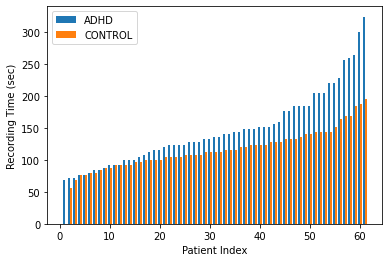

In [ ]:
x=list(range(1, 62))
x1=[i-0.2 for i in x]
x2=[i+0.2 for i in x]
t_control=list(t_control)
if len(t_control)!=61:
    t_control.append(0)
#print(len(x1))
#print(len(x2))
#print(len(list(t_adhd)))
#print(len(t_control))
plt.bar(x1, sorted(list(t_adhd)), label='ADHD',width=0.4)
plt.bar(x2, sorted(t_control), label='CONTROL',width=0.4)
plt.xlabel('Patient Index')
plt.ylabel('Recording Time (sec)')
plt.legend()
plt.savefig('recording_time.png')
plt.show()

## Create MI Table for GNN Construction

In [ ]:
# create mutual information table 
(epochs, channels, frames) = ADHD_dataset.shape
mi_table = np.zeros([epochs, channels, channels])
for j in range(epochs):
    if j%10==0: 
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("ADHD", j, current_time)
    example = ADHD_dataset[j,:,:]
    for k in range(channels):
        x = np.delete(example,k,axis=0)
        y = example[k,:]
        mi = mutual_info_regression(x.transpose(),y) #  This is where MI is calculated
        mi = np.insert(mi,k,0)  # assign 0 for position (k,k) (self-loop value 0)

        mi_table[j,k,:] = mi
        
# mi_table dimension: (patients, epochs, channel, channel)
np.save(mi_dir_adhd, mi_table)        


# create mutual information table 
(epochs, channels, frames) = CONTROL_dataset.shape
mi_table = np.zeros([epochs, channels, channels])
for j in range(epochs):
    if j%10==0: 
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("CONTROL", j, current_time)
    example = CONTROL_dataset[j,:,:]
    for k in range(channels):
        x = np.delete(example,k,axis=0)
        y = example[k,:]
        mi = mutual_info_regression(x.transpose(),y)
        mi = np.insert(mi,k,0)

        mi_table[j,k,:] = mi    
    
# mi_table dimension: (patients, epochs, channel, channel)
np.save(mi_dir_control, mi_table)

ADHD 0 17:55:48
ADHD 10 17:56:00
ADHD 20 17:56:12
ADHD 30 17:56:24
ADHD 40 17:56:35
ADHD 50 17:56:47
ADHD 60 17:56:58
ADHD 70 17:57:10
ADHD 80 17:57:21
ADHD 90 17:57:33
ADHD 100 17:57:45
ADHD 110 17:57:56
ADHD 120 17:58:09
ADHD 130 17:58:20
ADHD 140 17:58:32
ADHD 150 17:58:44
ADHD 160 17:58:56
ADHD 170 17:59:08
ADHD 180 17:59:20
ADHD 190 17:59:31
ADHD 200 17:59:43
ADHD 210 17:59:54
ADHD 220 18:00:06
ADHD 230 18:00:17
ADHD 240 18:00:29
ADHD 250 18:00:41
ADHD 260 18:00:52
ADHD 270 18:01:04
ADHD 280 18:01:15
ADHD 290 18:01:26
ADHD 300 18:01:38
ADHD 310 18:01:49
ADHD 320 18:02:01
ADHD 330 18:02:12
ADHD 340 18:02:24
ADHD 350 18:02:36
ADHD 360 18:02:47
ADHD 370 18:02:59
ADHD 380 18:03:11
ADHD 390 18:03:22
ADHD 400 18:03:34
ADHD 410 18:03:45
ADHD 420 18:03:57
ADHD 430 18:04:09
ADHD 440 18:04:21
ADHD 450 18:04:33
ADHD 460 18:04:45
ADHD 470 18:04:57
ADHD 480 18:05:08
ADHD 490 18:05:20
ADHD 500 18:05:31
ADHD 510 18:05:44
ADHD 520 18:05:55
ADHD 530 18:06:07
ADHD 540 18:06:19
ADHD 550 18:06:31
ADH

## Sample MI table

ADHD MI table shape: (2231, 20, 20)
CONTROL MI table shape: (1757, 20, 20)


Text(0.5, 1.0, 'CONTROL 19 Channels')

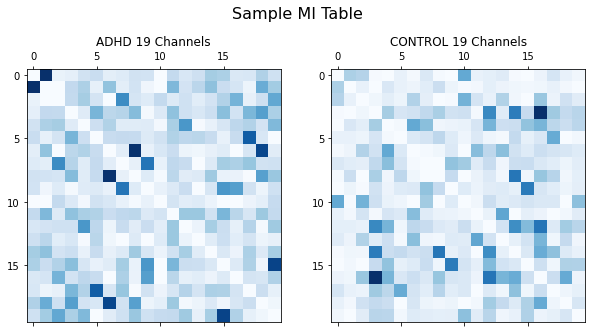

In [ ]:
a= np.load(mi_dir_adhd)
b = np.load(mi_dir_control)
print(f'ADHD MI table shape: {a.shape}')
print(f'CONTROL MI table shape: {b.shape}')
fig, axs = plt.subplots(1,2, figsize=(10,5.5))
fig.suptitle('Sample MI Table', fontsize=16)
axs[0].matshow(a[1700,:,:], cmap=plt.cm.Blues)
axs[0].set_title('ADHD 19 Channels')
axs[1].matshow(b[1700,:,:], cmap=plt.cm.Blues)
axs[1].set_title('CONTROL 19 Channels')

# Create Mutual Information with Overlap for CNN model
## Create a overlapped numpy channel array with preprocessed signals 

In [ ]:
#  Dataset contained channel label file. I was able to manually match the numeric values to each channels and create this sequence
overlap_seq = [3,11,1,17,2,12,4,6,14,16,10,8,19,8,18,6,4,17,3,5,7,19,9,15,7,13,5,3,11]

(epochs, channel, time)=ADHD_dataset.shape
overlap_channels = len(overlap_seq)

ADHD_overlap = np.zeros((epochs,overlap_channels,512))

for epoch in range(epochs):  # for each epoch, rearange channels.
    for i in range(overlap_channels):
        index = overlap_seq[i]-1
        ADHD_overlap[epoch, i, :] = ADHD_dataset[epoch,index,:]

print('ADHD overlap dimension: ', ADHD_overlap.shape)

ADHD overlap dimension:  (2231, 29, 512)


In [ ]:
# Repeat for contol group
overlap_seq = [3,11,1,17,2,12,4,6,14,16,10,8,19,8,18,6,4,17,3,5,7,19,9,15,7,13,5,3,11]

(epochs, channel, time)=CONTROL_dataset.shape
overlap_channels = len(overlap_seq)

CONTROL_overlap = np.zeros((epochs,overlap_channels,512))

for epoch in range(epochs):
    for i in range(overlap_channels):
        index = overlap_seq[i]-1
        CONTROL_overlap[epoch, i, :] = CONTROL_dataset[epoch,index,:]

print('CONTROL overlap dimension: ', CONTROL_overlap.shape)

CONTROL overlap dimension:  (1757, 29, 512)


## Create MI table with overlap. 29x29 adjacency matrix

In [ ]:
overlap_seq = np.array([3,11,1,17,2,12,4,6,14,16,10,8,19,8,18,6,4,17,3,5,7,19,9,15,7,13,5,3,11])

# create mutual information table 
(epochs, channels, frames) = ADHD_overlap.shape
mi_table = np.zeros([epochs, channels, channels])
for j in range(epochs):
    if j%10==0: 
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("ADHD overlap", j, current_time)
    
    example = ADHD_overlap[j,:,:]

    for k in range(channels):
        pos = np.where(np.array(overlap_seq) == overlap_seq[k])[0] # find indices for self loop
        x = np.delete(example,k,axis=0) 
        y = example[k,:]
        mi = mutual_info_regression(x.transpose(),y)  # calculate MI here
        mi = np.insert(mi,k,0) # assign 0 for position (k,k) (self-loop value 0)
        mi_table[j,k,:] = mi
        mi_table[j,k,pos] = 0 # assign 0 for other self loop indices that were found

# mi_table dimension: (patients, epochs, channel, channel)
np.save(mi_dir_adhd_overlap, mi_table)
        
        
# create mutual information table 
(epochs, channels, frames) = CONTROL_overlap.shape
mi_table = np.zeros([epochs, channels, channels])
for j in range(epochs):
    if j%10==0: 
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("CONTROL overlap", j, current_time)
    
    example = CONTROL_overlap[j,:,:]

    for k in range(channels):
        pos = np.where(np.array(overlap_seq) == overlap_seq[k])[0] # find indices for self loop
        x = np.delete(example,k,axis=0) 
        y = example[k,:]
        mi = mutual_info_regression(x.transpose(),y)
        mi = np.insert(mi,k,0) # assign 0 for position (k,k)
        mi_table[j,k,:] = mi
        mi_table[j,k,pos] = 0 # assign 0 for other self loop indices that were found

# mi_table dimension: (patients, epochs, channel, channel)
np.save(mi_dir_control_overlap, mi_table)

ADHD overlap 0 19:13:30
ADHD overlap 10 19:13:55
ADHD overlap 20 19:14:20
ADHD overlap 30 19:14:45
ADHD overlap 40 19:15:09
ADHD overlap 50 19:15:34
ADHD overlap 60 19:15:58
ADHD overlap 70 19:16:23
ADHD overlap 80 19:16:48
ADHD overlap 90 19:17:13
ADHD overlap 100 19:17:37
ADHD overlap 110 19:18:01
ADHD overlap 120 19:18:26
ADHD overlap 130 19:18:50
ADHD overlap 140 19:19:15
ADHD overlap 150 19:19:40
ADHD overlap 160 19:20:05
ADHD overlap 170 19:20:31
ADHD overlap 180 19:20:55
ADHD overlap 190 19:21:19
ADHD overlap 200 19:21:45
ADHD overlap 210 19:22:09
ADHD overlap 220 19:22:34
ADHD overlap 230 19:22:58
ADHD overlap 240 19:23:23
ADHD overlap 250 19:23:48
ADHD overlap 260 19:24:12
ADHD overlap 270 19:24:37
ADHD overlap 280 19:25:01
ADHD overlap 290 19:25:26
ADHD overlap 300 19:25:51
ADHD overlap 310 19:26:15
ADHD overlap 320 19:26:40
ADHD overlap 330 19:27:04
ADHD overlap 340 19:27:29
ADHD overlap 350 19:27:53
ADHD overlap 360 19:28:18
ADHD overlap 370 19:28:42
ADHD overlap 380 19:29:

CONTROL overlap 790 21:18:54
CONTROL overlap 800 21:19:24
CONTROL overlap 810 21:19:50
CONTROL overlap 820 21:20:15
CONTROL overlap 830 21:20:41
CONTROL overlap 840 21:21:06
CONTROL overlap 850 21:21:31
CONTROL overlap 860 21:21:56
CONTROL overlap 870 21:22:21
CONTROL overlap 880 21:22:47
CONTROL overlap 890 21:23:12
CONTROL overlap 900 21:23:37
CONTROL overlap 910 21:24:02
CONTROL overlap 920 21:24:26
CONTROL overlap 930 21:24:52
CONTROL overlap 940 21:25:16
CONTROL overlap 950 21:25:41
CONTROL overlap 960 21:26:07
CONTROL overlap 970 21:26:32
CONTROL overlap 980 21:26:57
CONTROL overlap 990 21:27:21
CONTROL overlap 1000 21:27:46
CONTROL overlap 1010 21:28:16
CONTROL overlap 1020 21:28:41
CONTROL overlap 1030 21:29:06
CONTROL overlap 1040 21:29:31
CONTROL overlap 1050 21:29:57
CONTROL overlap 1060 21:30:23
CONTROL overlap 1070 21:30:48
CONTROL overlap 1080 21:31:14
CONTROL overlap 1090 21:31:39
CONTROL overlap 1100 21:32:05
CONTROL overlap 1110 21:32:30
CONTROL overlap 1120 21:32:55
C

ADHD MI table shape: (2231, 29, 29)
CONTROL MI table shape: (1757, 29, 29)


Text(0.5, 1.0, 'CONTROL 29 Channels')

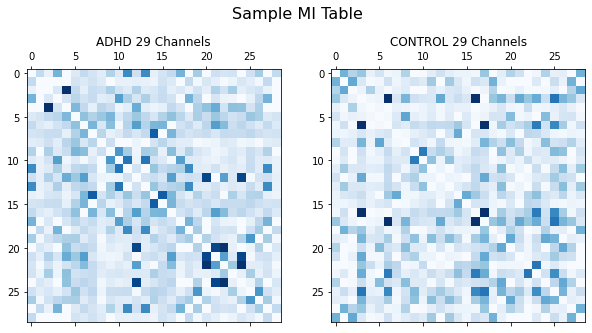

In [ ]:
a= np.load(mi_dir_adhd_overlap)
b = np.load(mi_dir_control_overlap)
print(f'ADHD MI table shape: {a.shape}')
print(f'CONTROL MI table shape: {b.shape}')
fig2, axs2 = plt.subplots(1,2, figsize=(10,5.5))
fig2.suptitle('Sample MI Table', fontsize=16)
axs2[0].matshow(a[1700,:,:], cmap=plt.cm.Blues)
axs2[0].set_title('ADHD 29 Channels')
axs2[1].matshow(b[1700,:,:], cmap=plt.cm.Blues)
axs2[1].set_title('CONTROL 29 Channels')